#### 08 Ensemble Modeling for Pneumonia Detection

**Goal:**  
Combine predictions from multiple top models (e.g., DenseNet, ResNet, EfficientNet, VGG16) using ensemble methods (probability averaging and majority voting) to potentially improve classification accuracy.

- Input: Saved models, test data
- Output: Ensemble predictions, metrics, and comparison with individual models


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
base_dir = '../chest_xray'
test_dir = os.path.join(base_dir, 'test')
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
CLASSES = ['NORMAL', 'PNEUMONIA']
model_dir = 'models/saved'


In [3]:
tl_model_files = [
    ('resnet50_best.h5', 'ResNet50', tf.keras.applications.resnet.preprocess_input, 'rgb'),
    ('densenet121_best.h5', 'DenseNet121', tf.keras.applications.densenet.preprocess_input, 'rgb'),
    ('efficientnetb0_best.h5', 'EfficientNetB0', tf.keras.applications.efficientnet.preprocess_input, 'rgb'),
    ('vgg16_best.h5', 'VGG16', tf.keras.applications.vgg16.preprocess_input, 'rgb')
]


In [4]:
# Collect image file paths and true labels once
image_paths = []
labels = []

for idx, label in enumerate(CLASSES):
    label_dir = os.path.join(test_dir, label)
    for fname in os.listdir(label_dir):
        image_paths.append(os.path.join(label_dir, fname))
        labels.append(idx)

labels = np.array(labels)

print(f"Collected {len(image_paths)} images from test set.")


Collected 624 images from test set.


In [5]:
def get_model_probs(model_path, preprocess_func, color_mode='rgb'):
    model = tf.keras.models.load_model(model_path)
    probs = []
    for img_path in image_paths:
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE, color_mode=color_mode)
        img_arr = tf.keras.preprocessing.image.img_to_array(img)
        img_arr = np.expand_dims(img_arr, axis=0)
        img_arr = preprocess_func(img_arr)
        prob = model.predict(img_arr, verbose=0)[0][0]
        probs.append(prob)
    return np.array(probs)


In [7]:
# Stack probabilities: shape = (num_models, num_samples)
# Get predictions from each model
probs_dict = {}
for model_file, model_name, preprocess_func, color_mode in tl_model_files:
    model_path = os.path.join(model_dir, model_file)
    print(f"Loading {model_name}...")
    probs_dict[model_name] = get_model_probs(model_path, preprocess_func, color_mode)
    print(f"Completed {model_name} predictions")
all_probs = np.array(list(probs_dict.values()))
avg_probs = np.mean(all_probs, axis=0)
ensemble_pred = (avg_probs > 0.5).astype(int)

# Evaluate
acc = accuracy_score(labels, ensemble_pred)
auc = roc_auc_score(labels, avg_probs)
report = classification_report(labels, ensemble_pred, target_names=CLASSES)
cm = confusion_matrix(labels, ensemble_pred)
print("=== Ensemble (Probability Averaging) ===")
print(f"Accuracy: {acc:.4f} | AUC: {auc:.4f}")
print(report)


Loading ResNet50...
Completed ResNet50 predictions
Loading DenseNet121...
Completed DenseNet121 predictions
Loading EfficientNetB0...
Completed EfficientNetB0 predictions
Loading VGG16...
Completed VGG16 predictions
=== Ensemble (Probability Averaging) ===
Accuracy: 0.8574 | AUC: 0.9701
              precision    recall  f1-score   support

      NORMAL       0.95      0.65      0.77       234
   PNEUMONIA       0.83      0.98      0.90       390

    accuracy                           0.86       624
   macro avg       0.89      0.82      0.84       624
weighted avg       0.87      0.86      0.85       624



In [8]:
all_preds = (all_probs > 0.5).astype(int)
vote_pred = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=all_preds)

# Evaluate
acc_vote = accuracy_score(labels, vote_pred)
auc_vote = roc_auc_score(labels, np.mean(all_preds, axis=0))
report_vote = classification_report(labels, vote_pred, target_names=CLASSES)
cm_vote = confusion_matrix(labels, vote_pred)
print("=== Ensemble (Majority Voting) ===")
print(f"Accuracy: {acc_vote:.4f} | AUC: {auc_vote:.4f}")
print(report_vote)


=== Ensemble (Majority Voting) ===
Accuracy: 0.8782 | AUC: 0.9021
              precision    recall  f1-score   support

      NORMAL       0.95      0.71      0.81       234
   PNEUMONIA       0.85      0.98      0.91       390

    accuracy                           0.88       624
   macro avg       0.90      0.85      0.86       624
weighted avg       0.89      0.88      0.87       624



In [9]:
summary = []
for i, (name, probs) in enumerate(probs_dict.items()):
    pred = (probs > 0.5).astype(int)
    acc = accuracy_score(labels, pred)
    auc = roc_auc_score(labels, probs)
    report = classification_report(labels, pred, target_names=CLASSES, output_dict=True)
    summary.append({
        "Model": name,
        "Accuracy": acc,
        "AUC": auc,
        "Precision": report['weighted avg']['precision'],
        "Recall": report['weighted avg']['recall'],
        "F1-score": report['weighted avg']['f1-score']
    })
# Add ensemble results
summary.append({
    "Model": "Ensemble (Avg)",
    "Accuracy": acc,
    "AUC": auc,
    "Precision": None,
    "Recall": None,
    "F1-score": None
})
summary.append({
    "Model": "Ensemble (Vote)",
    "Accuracy": acc_vote,
    "AUC": auc_vote,
    "Precision": None,
    "Recall": None,
    "F1-score": None
})
df_summary = pd.DataFrame(summary)
df_summary = df_summary.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)
df_summary


,Model,Accuracy,AUC,Precision,Recall,F1-score
0,Ensemble (Vote),0.878205,0.902104,NaN,NaN,NaN
1,ResNet50,0.870192,0.964672,0.880925,0.870192,0.864947
2,EfficientNetB0,0.868590,0.958503,0.880717,0.868590,0.862928
3,DenseNet121,0.838141,0.955139,0.856085,0.838141,0.828477
4,VGG16,0.826923,0.959752,0.850826,0.826923,0.814480
5,Ensemble (Avg),0.826923,0.959752,NaN,NaN,NaN


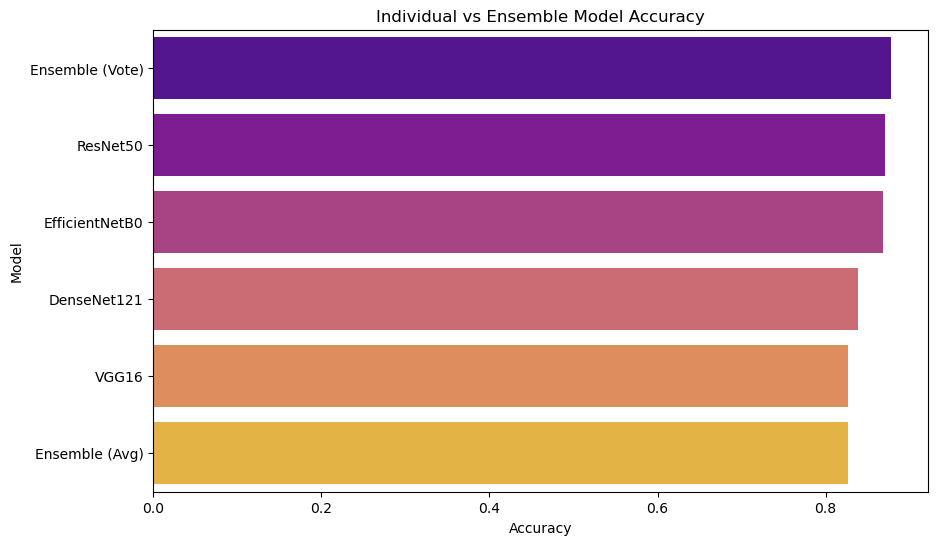

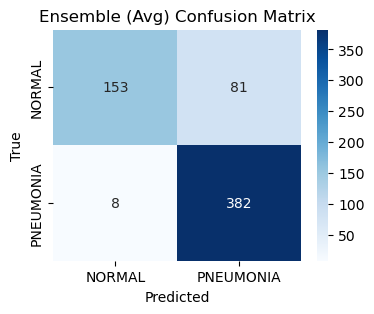

In [11]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(x='Accuracy', y='Model', data=df_summary, palette='plasma')
plt.xlabel("Accuracy")
plt.title("Individual vs Ensemble Model Accuracy")
plt.show()

# Confusion matrix for ensemble (probability averaging)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title("Ensemble (Avg) Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
